In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data import load_data_excel, convert_numeric_columns
from src.features import encode_categorical_feature, get_simplified_names
from src.experiments import (
    prepare_data_random_split, train_xgboost_models
)
from src.visu import plot_ml_results

# Load data
data = load_data_excel('../data/sources/Donnees_IA_2025.xlsx')

# Define variables
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut",
    "EM porc croissance (kcal) kcal/kg brut", "EN porc croissance (kcal) kcal/kg brut",
    "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut",
    "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

# Convert numeric columns
data = convert_numeric_columns(data, vars_expl + vars_cibles)

# Get simplified names
simplified_names = get_simplified_names()

print(f" Data loaded: {len(data)} observations")

 Data loaded: 6376 observations


## In-Distribution XGBoost Regression - Feature Importance & Robustness Testing

Test how model performance varies with different input features and categorical encodings.

### Scenario 1: All Chemical Composition Variables (Baseline)

In [3]:
# Prepare data with random split
X_train_all, X_test_all, y_train_all, y_test_all = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Train XGBoost models
results_all, metrics_all, models_all = train_xgboost_models(
    X_train_all, X_test_all, y_train_all, y_test_all,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 1: All Chemical Composition Variables")
print(f"Train size: {len(X_train_all)}, Test size: {len(X_test_all)}")
print(f"R² variance weighted: {metrics_all['R2_variance_weighted']:.4f}")
print(f"R² uniform: {metrics_all['R2_uniform']:.4f}")
print(f"R² min: {metrics_all['R2_min']:.4f}")
print("\nDetailed results:")
print(results_all.to_string(index=False))


Scenario 1: All Chemical Composition Variables
Train size: 5100, Test size: 1276
R² variance weighted: 0.9899
R² uniform: 0.9903
R² min: 0.9879

Detailed results:
Variable cible   MAE  RMSE     R2
            EB 31.02 52.96 0.9928
       ED porc 49.31 93.01 0.9879
       EM porc 45.48 84.46 0.9892
       EN porc 35.00 58.44 0.9933
      EMAn coq 48.93 82.59 0.9895
   EMAn poulet 49.61 84.54 0.9883
           UFL  0.02  0.03 0.9899
           UFV  0.02  0.04 0.9880
          PDIA  2.73  8.02 0.9906
           PDI  2.77  8.13 0.9900
      BalProRu  3.35  7.53 0.9939


### Scenario 2: MS + PB Only (Minimal Features)

In [4]:
# Scenario 2: Reduced features
features_reduced = ["MS % brut", "PB % brut"]
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = prepare_data_random_split(
    data, features_reduced, vars_cibles, test_size=0.2, random_state=42
)

results_reduced, metrics_reduced, models_reduced = train_xgboost_models(
    X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 2: MS + PB Only")
print(f"Train size: {len(X_train_reduced)}, Test size: {len(X_test_reduced)}")
print(f"R² variance weighted: {metrics_reduced['R2_variance_weighted']:.4f}")
print(f"Performance drop vs all features: {metrics_all['R2_variance_weighted'] - metrics_reduced['R2_variance_weighted']:+.4f}")
print(results_reduced.to_string(index=False))


Scenario 2: MS + PB Only
Train size: 5100, Test size: 1276
R² variance weighted: 0.4208
Performance drop vs all features: +0.5691
Variable cible    MAE   RMSE     R2
            EB 225.91 364.43 0.6596
       ED porc 411.00 607.56 0.4855
       EM porc 412.11 609.83 0.4392
       EN porc 377.90 569.02 0.3650
      EMAn coq 451.91 667.24 0.3147
   EMAn poulet 440.80 647.38 0.3139
           UFL   0.14   0.22 0.4336
           UFV   0.17   0.25 0.4058
          PDIA  15.37  27.80 0.8875
           PDI  15.28  27.57 0.8854
      BalProRu  16.96  28.96 0.9105


### Scenario 3: All Features + Classe & Nom Encoded

In [5]:
# Scenario 3: All features + encoded categorical
X_train_cat, X_test_cat, y_train_cat, y_test_cat = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Add encoded features
X_train_cat, X_test_cat = encode_categorical_feature(
    X_train_cat, X_test_cat, data, "Classe"
)
X_train_cat, X_test_cat = encode_categorical_feature(
    X_train_cat, X_test_cat, data, "Nom"
)

results_cat, metrics_cat, models_cat = train_xgboost_models(
    X_train_cat, X_test_cat, y_train_cat, y_test_cat,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 3: All Features + Classe + Nom Encoded")
print(f"Train size: {len(X_train_cat)}, Test size: {len(X_test_cat)}")
print(f"R² variance weighted: {metrics_cat['R2_variance_weighted']:.4f}")
print(f"Performance gain vs composition only: {metrics_cat['R2_variance_weighted'] - metrics_all['R2_variance_weighted']:+.4f}")
print(results_cat.to_string(index=False))


Scenario 3: All Features + Classe + Nom Encoded
Train size: 5100, Test size: 1276
R² variance weighted: 0.9913
Performance gain vs composition only: +0.0014
Variable cible   MAE  RMSE     R2
            EB 30.06 52.77 0.9929
       ED porc 45.87 75.48 0.9921
       EM porc 43.41 76.37 0.9912
       EN porc 32.95 54.84 0.9941
      EMAn coq 46.90 81.52 0.9898
   EMAn poulet 46.73 82.41 0.9889
           UFL  0.02  0.03 0.9914
           UFV  0.02  0.04 0.9885
          PDIA  1.86  5.57 0.9955
           PDI  2.06  5.87 0.9948
      BalProRu  2.76  6.38 0.9957


### Comparative Results

In [20]:
# Create comparison DataFrame for first 3 scenarios
comparison_df = pd.DataFrame({
    'Scenario': [
        'All Features',
        'MS + PB Only',
        'All + Classe + Nom'
    ],
    'R² Variance Weighted': [
        metrics_all['R2_variance_weighted'],
        metrics_reduced['R2_variance_weighted'],
        metrics_cat['R2_variance_weighted']
    ]
})


COMPARISON TABLE - First 3 Scenarios
          Scenario  R² Variance Weighted
      All Features                0.9899
      MS + PB Only                0.4208
All + Classe + Nom                0.9913


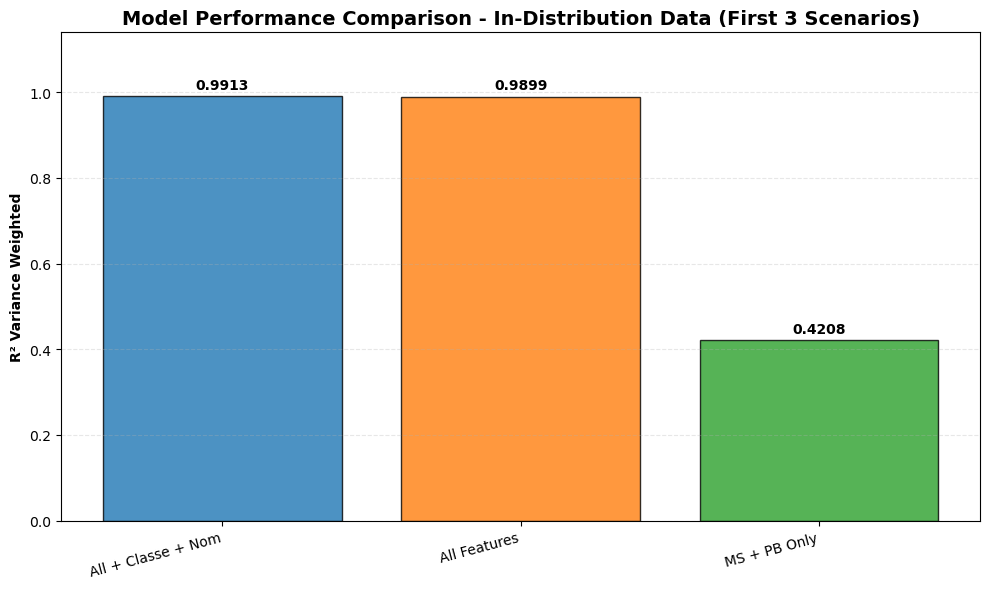

In [21]:

print("\n" + "="*80)
print("COMPARISON TABLE - First 3 Scenarios")
print("="*80)
print(comparison_df.to_string(index=False))

# Plot using new function
fig = plot_ml_results(
    comparison_df,
    x_col='Scenario',
    y_col='R² Variance Weighted',
    title='Model Performance Comparison - In-Distribution Data (First 3 Scenarios)',
    figsize=(10, 6)
)
plt.show()

### Scenario 4: Classe Only (Encoded)

In [11]:
# Scenario 4: Classe only
X_train_classe, X_test_classe, y_train_classe, y_test_classe = prepare_data_random_split(
    data, [], vars_cibles, test_size=0.2, random_state=42
)

indices_train_c = X_train_classe.index
indices_test_c = X_test_classe.index

X_train_classe, X_test_classe = encode_categorical_feature(
    X_train_classe, X_test_classe, data, "Classe"
)

results_classe, metrics_classe, models_classe = train_xgboost_models(
    X_train_classe, X_test_classe, y_train_classe, y_test_classe,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 4: Classe Only (Encoded)")
print(f"Train size: {len(X_train_classe)}, Test size: {len(X_test_classe)}")
print(f"R² variance weighted: {metrics_classe['R2_variance_weighted']:.4f}")
print(results_classe.to_string(index=False))


Scenario 4: Classe Only (Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.4393
Variable cible    MAE   RMSE     R2
            EB 328.57 447.32 0.4871
       ED porc 495.93 640.94 0.4274
       EM porc 475.49 611.22 0.4367
       EN porc 396.26 507.10 0.4957
      EMAn coq 486.85 614.69 0.4184
   EMAn poulet 483.06 605.53 0.3997
           UFL   0.16   0.21 0.4719
           UFV   0.18   0.24 0.4730
          PDIA  36.49  59.80 0.4795
           PDI  36.53  59.33 0.4691
      BalProRu  48.81  69.86 0.4790


### Scenario 5: Nom Only (Encoded)

In [12]:
# Scenario 5: Nom only
X_train_nom, X_test_nom, y_train_nom, y_test_nom = prepare_data_random_split(
    data, [], vars_cibles, test_size=0.2, random_state=42
)

X_train_nom, X_test_nom = encode_categorical_feature(
    X_train_nom, X_test_nom, data, "Nom"
)

results_nom, metrics_nom, models_nom = train_xgboost_models(
    X_train_nom, X_test_nom, y_train_nom, y_test_nom,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 5: Nom Only (Encoded)")
print(f"Train size: {len(X_train_nom)}, Test size: {len(X_test_nom)}")
print(f"R² variance weighted: {metrics_nom['R2_variance_weighted']:.4f}")
print(results_nom.to_string(index=False))


Scenario 5: Nom Only (Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.9338
Variable cible    MAE   RMSE     R2
            EB 101.14 155.35 0.9381
       ED porc 142.02 228.14 0.9275
       EM porc 136.16 219.75 0.9272
       EN porc 106.78 172.24 0.9418
      EMAn coq 126.89 204.92 0.9354
   EMAn poulet 122.42 198.13 0.9357
           UFL   0.04   0.07 0.9426
           UFV   0.05   0.08 0.9440
          PDIA   5.41  10.97 0.9825
           PDI   5.77  11.44 0.9803
      BalProRu  11.32  18.96 0.9616


### Scenario 6: MS + PB + Nom (Encoded)

In [13]:
# Scenario 6: MS + PB + Nom encoded
features_mspb = ["MS % brut", "PB % brut"]
X_train_mspb_nom, X_test_mspb_nom, y_train_mspb_nom, y_test_mspb_nom = prepare_data_random_split(
    data, features_mspb, vars_cibles, test_size=0.2, random_state=42
)

X_train_mspb_nom, X_test_mspb_nom = encode_categorical_feature(
    X_train_mspb_nom, X_test_mspb_nom, data, "Nom"
)

results_mspb_nom, metrics_mspb_nom, models_mspb_nom = train_xgboost_models(
    X_train_mspb_nom, X_test_mspb_nom, y_train_mspb_nom, y_test_mspb_nom,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 6: MS + PB + Nom (Encoded)")
print(f"Train size: {len(X_train_mspb_nom)}, Test size: {len(X_test_mspb_nom)}")
print(f"R² variance weighted: {metrics_mspb_nom['R2_variance_weighted']:.4f}")
print(results_mspb_nom.to_string(index=False))


Scenario 6: MS + PB + Nom (Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.9592
Variable cible    MAE   RMSE     R2
            EB  70.75 121.02 0.9625
       ED porc 113.29 171.74 0.9589
       EM porc 112.44 170.26 0.9563
       EN porc  91.99 142.80 0.9600
      EMAn coq 103.87 160.15 0.9605
   EMAn poulet 104.42 161.85 0.9571
           UFL   0.04   0.06 0.9601
           UFV   0.04   0.06 0.9609
          PDIA   1.46   4.28 0.9973
           PDI   1.72   4.21 0.9973
      BalProRu   2.19   3.65 0.9986


### Extended Comparative Results (All Scenarios)

In [16]:
# Extended comparison with all 6 scenarios
comparison_all_df = pd.DataFrame({
    'Scenario': [
        'All Features',
        'MS + PB Only',
        'All + Classe + Nom',
        'Classe Only',
        'Nom Only',
        'MS + PB + Nom'
    ],
    'R² Variance Weighted': [
        metrics_all['R2_variance_weighted'],
        metrics_reduced['R2_variance_weighted'],
        metrics_cat['R2_variance_weighted'],
        metrics_classe['R2_variance_weighted'],
        metrics_nom['R2_variance_weighted'],
        metrics_mspb_nom['R2_variance_weighted']
    ]
})


EXTENDED COMPARISON TABLE - All 6 Scenarios
          Scenario  R² Variance Weighted
      All Features                0.9899
      MS + PB Only                0.4208
All + Classe + Nom                0.9913
       Classe Only                0.4393
          Nom Only                0.9338
     MS + PB + Nom                0.9592


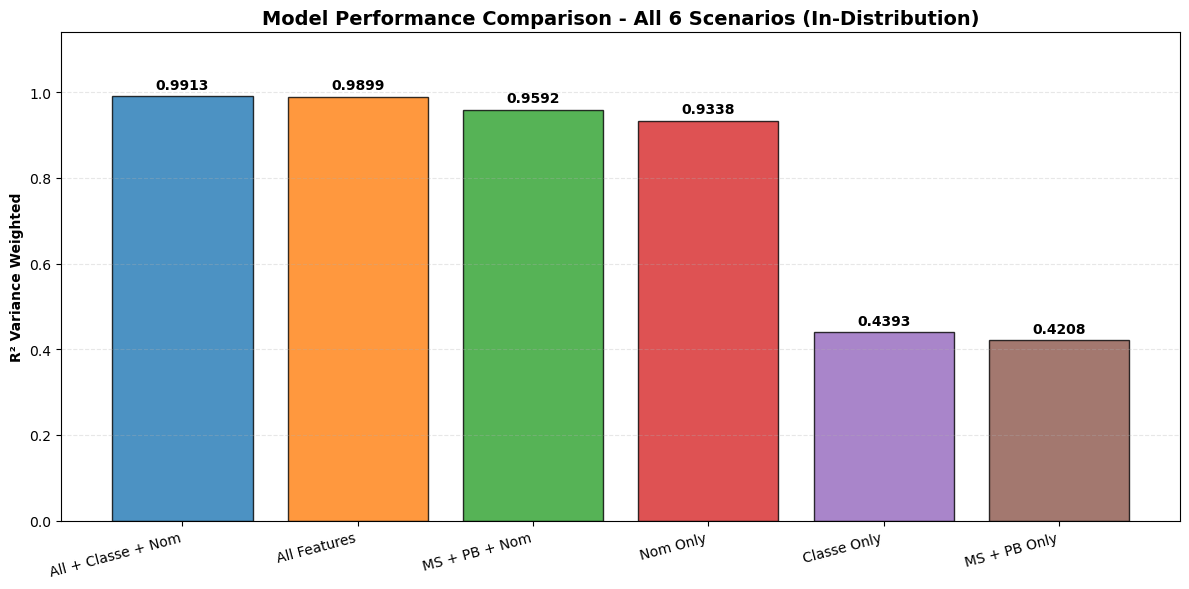

In [23]:

print("\n" + "="*80)
print("EXTENDED COMPARISON TABLE - All 6 Scenarios")
print("="*80)
print(comparison_all_df.to_string(index=False))

# Plot all 6 scenarios
fig = plot_ml_results(
    comparison_all_df,
    x_col='Scenario',
    y_col='R² Variance Weighted',
    title='Model Performance Comparison - All 6 Scenarios (In-Distribution)',
    figsize=(12, 6)
)
plt.show()

All + Nom only -> modèle parfait, plot les résidus pour diapo --> validation croisée + refaire un graphique propre de l'importance des features (barplot)


Baseline -> prédire les valeurs de table moyenne.



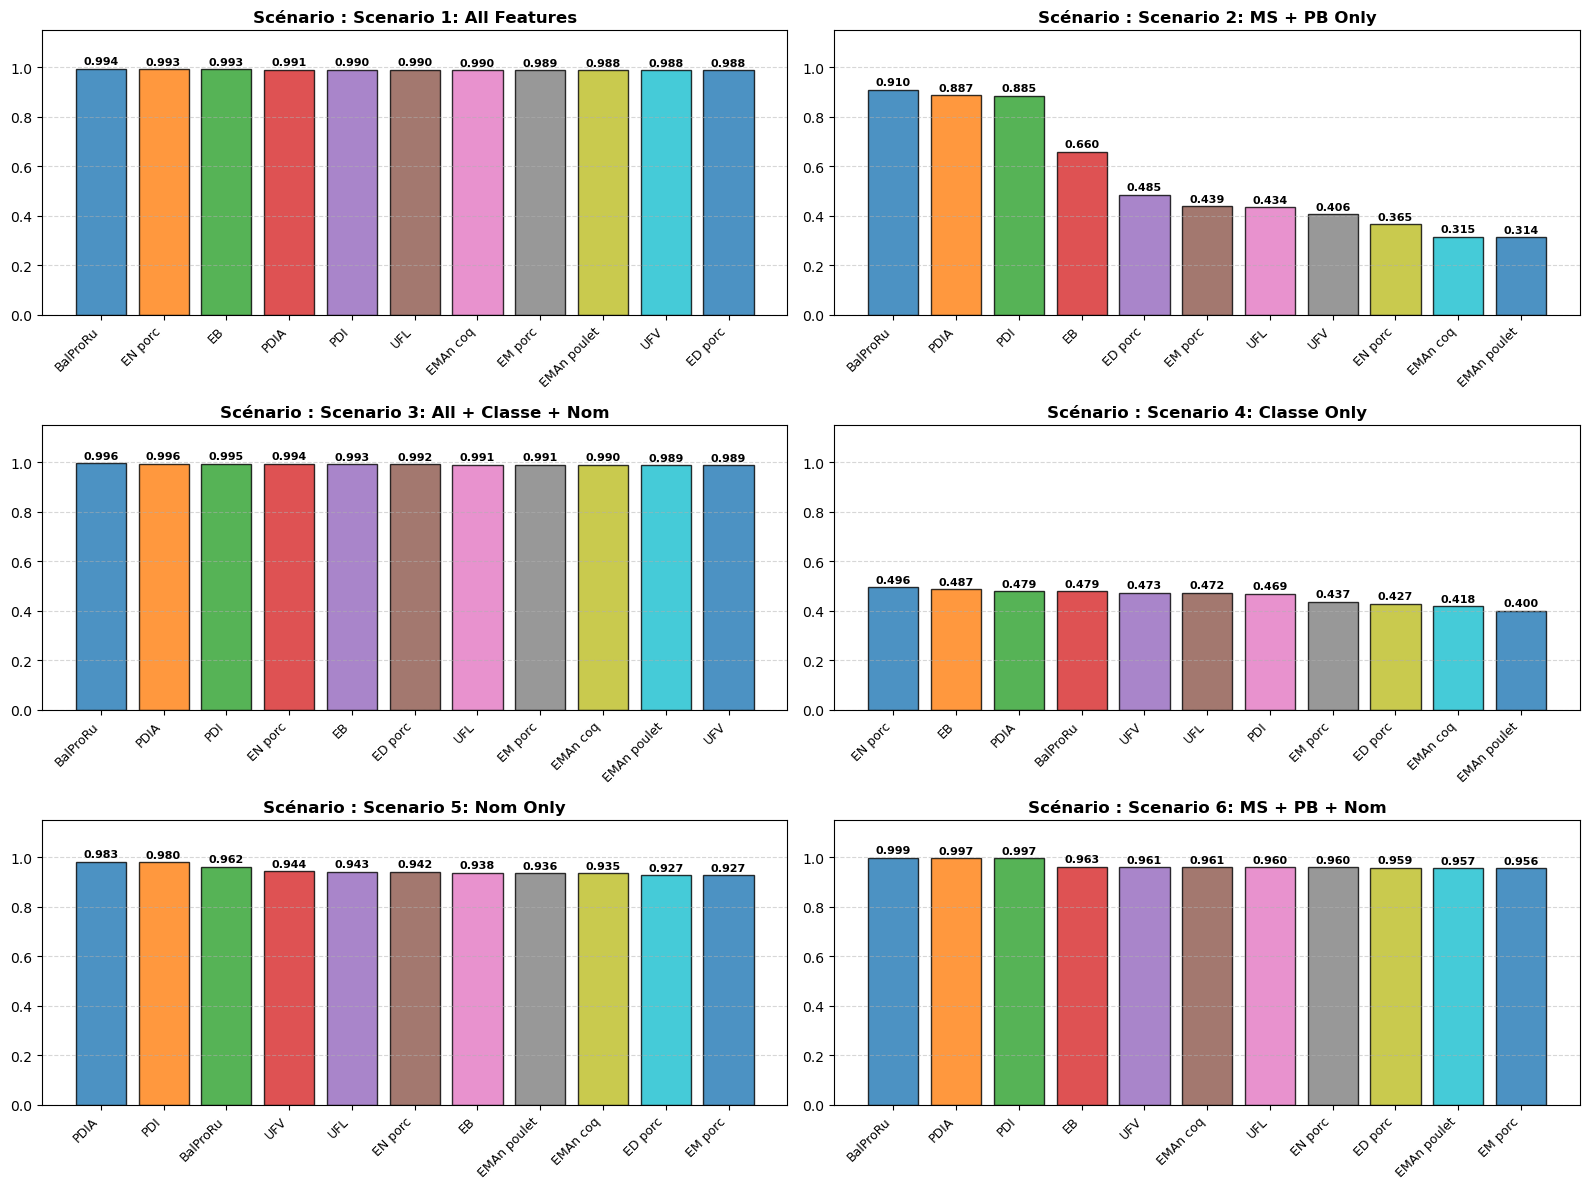

In [19]:
# Grid of R² by target variable for all 6 scenarios
all_detailed_results = {
    'Scenario 1: All Features': results_all,
    'Scenario 2: MS + PB Only': results_reduced,
    'Scenario 3: All + Classe + Nom': results_cat,
    'Scenario 4: Classe Only': results_classe,
    'Scenario 5: Nom Only': results_nom,
    'Scenario 6: MS + PB + Nom': results_mspb_nom
}

# Alternative visualization for detailed results
fig = plot_ml_results(
    all_detailed_results,
    y_col='R2',
    figsize=(16, 12)
)
plt.show()